# Lesson 3: binned and unbinned fits

## part 1: $\chi^2$ fits

$\chi^2$ describes the agreement between a predictive function $g(x)$ and a set of $n$ measurements $\{(x_i,y_i)\}$ and their uncertainties $\sigma_i$. It is a meausre of the square of the total deviation from $g(x)$:

\begin{align}
\chi^2 = \sum_{i=1}^{n} \bigg[ \frac{y_i - g(x_i)}{\sigma_i}\bigg]^2.
\end{align}

The $\chi^2$ *distribution*, or the $\chi^2$ probability density function, is given by:

\begin{align}
f(\chi^2; n) = \frac{2^{-n/2}}{\Gamma(n/2)} \chi^{n-2}e^{-\chi^2/2}.
\end{align}

If, instead of starting with a set $g(x)$ and calculating $\chi^2$ or the probability, you fit a function with $m$ free parameters, the $\chi^2$ distribution is a function of the number of degrees of freedom $n-m$ (not $n$ as shown above).

When you ask root for ```TMath::Prob(chi2,ndof)```, it's integrating the $\chi^2$ distribution in the range$[\chi^2,\infty]$

Let's start out with a simple example: fit a line with three points (with uncertainties!)

In [9]:
import ROOT
import numpy as np
ROOT.gStyle.SetOptStat(0)
%jsroot

In [12]:
my_canvas = ROOT.TCanvas("c","c",800,600)
f1 = ROOT.TF1("f1","3*x + 2.4",0,10);
my_data = ROOT.TH1D("my_data","my_data",10,0,10)
my_data.Sumw2()
for i in range(0,1000):
    my_data.Fill(f1.GetRandom(),0.001)    

#make the data deliberately a bit worse
f2 = ROOT.TF1("f2","2.*x - 3",0,10);
for i in range(0,100):
    my_data.Fill(f2.GetRandom(),0.1)    

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: my_data (Potential memory leak).
Warning in <TF1::GetRandom>: function:f2 has 15 negative values: abs assumed


Now we have some data, let's try to minimize the $\chi^2$ distribution with a linear function $g(x) = a*x + b$. This is a simple problem that is already solved for us - many times over. You could code up a function to minimise the $\chi^2$ yourself, or just use the inbuilt ROOT functionailty that can fit histograms:

https://root.cern.ch/doc/master/classTH1.html#a7e7d34c91d5ebab4fc9bba3ca47dabdd

This performs a $\chi^2$ fit by default. There are other options listed on the link, some of which we will explore later.

In [13]:
gx = ROOT.TF1("gx","pol1",0,10)
x = my_data.Fit("gx","V")

my_data.Draw()
my_canvas.Draw()


Covariance Matrix:

            	          p0          p1
p0          	   0.0016266  -0.0010561
p1          	  -0.0010561   0.0007007

Correlation Matrix:

            	          p0          p1
p0          	           1    -0.98926
p1          	    -0.98926           1

****************************************
Minimizer is Linear
Chi2                      =      15.0441
NDf                       =            8
p0                        =    -0.356642   +/-   0.0403314   
p1                        =     0.262028   +/-   0.0264707   


Info in <ROOT::Math::Fitter::DoLeastSquareFit>: use gradient from model function


So we fit a line to our data, but it would be good if we could quantify the results. How good is the fit? 

Usually we say that if $\chi^2/\mbox{nDoF}\sim 1$, the fit is good. Why?

How close does $\chi^2/\mbox{nDoF}$ have to be to one to be considered good? 

How might this change for different numbers of degrees of freedom?

In [4]:
#in principle you should be able to access this from the fit result, but for some reason it is returning a null pointer.
print 'chi squared probability:',ROOT.TMath.Prob(15.0441,8)

chi squared probability: 0.0582936140833


## part 2: the method of maximum likelihood

Now things start to get a bit more complicated.

In the above example, our data was binned (or e.g. two dimensional measurements with associated uncertainties along one variable, which would be more along the lines of what you'd have seen in labs in undergrad).

However, we do not generally want our results to be biased by our (usually arbitrary) choice of binning. 

Instead, we are going to maximize the likelihood function for a given fit function $f$:

\begin{align}
L(x;\theta) = \prod_{i=1}^N f(x_i;\theta).
\end{align}

where $x = (x_1,x_2,...x_N)$ is our set of $N$ measured quantities and $\theta = (\theta_1,\theta_2,..,\theta_m)$ are the set of $m$ parameters of $f$ we would like to estimate (fit).

In this case, the fit functions defined by each $\theta$ we want to test must be normalized (i.e., they need to be probability density functions). Each data point is assigned a probablity of occuring based on $f(x_i;\theta)$. 

Imagine we're fitting data to a gaussian, with test $\theta$ with mean 1 and width 1. If all of our data has $x > 10$, the product of the probabilities (likelihood) is going to be awfully low. But if our data were scattered right around $x \sim 1$, the likelihood will be high.

For some value $\theta = \hat{\theta}$, the likelihood function has its global maximum.

Something important to note is that you'll often come across log-likelihood, rather than likelihood. This is for the simple reason that sums are easier to deal with than products, and:

\begin{align}
-\ln L(x;\theta) = - \sum_{i=1}^N \ln f(x_i;\theta).
\end{align}

The negative sign comes in because when f is less than one, the log will be negative - but $f$ is a probability density function, and thus always less than one. 

Let's do an example (code from https://root.cern.ch/roofit-20-minutes):

In [15]:
# Set up model
# ---------------------
# Declare variables x,mean,sigma with associated name, title, initial
# value and allowed range

#Observable with lower and upper bound
mass = ROOT.RooRealVar("mass", "m_{X}", 5.2, 5.3)

#Fit parameters with starting value, lower bound, and upper bound
mean = ROOT.RooRealVar("mean", "mass of X", 5.28, 5.20,5.30)
sigma = ROOT.RooRealVar("sigma", "width of X", 0.0027,0.001,1.)

# Build Gaussian PDF for our resonance
signalModel = ROOT.RooGaussian("signalModel","signal PDF",mass,mean,sigma)

# Build background p.d.f 
a0 = ROOT.RooRealVar("a0", "a0", 0.5, 0., 1.)
a1 = ROOT.RooRealVar("a1", "a1", -0.2, 0., 1.)
bkg = ROOT.RooChebychev("bkg", "Background", mass, ROOT.RooArgList(a0, a1))

#--- Construct signal+background PDF ---
nsig = ROOT.RooRealVar("nsig","#signal events",200,0.,10000);
nbkg = ROOT.RooRealVar("nbkg","#background events",800,0.,10000)
model = ROOT.RooAddPdf("model","g+a",ROOT.RooArgList(signalModel,bkg),ROOT.RooArgList(nsig,nbkg))

c = ROOT.TCanvas("c", "c", 800, 600)

# Construct plot frame in 'x'
xframe = mass.frame(ROOT.RooFit.Title("resonance search!"))  # RooPlot

#We can now use this p.d.f. to generate an unbinned toy dataset, fit the p.d.f to that 
#dataset using an unbinned maximum likelihood fit
#and visualise the data with the p.d.f overlaid.

# --- Generate a toyMC sample from composite PDF ---
data = model.generate(ROOT.RooArgSet(mass), 2000)

## --- Perform extended ML fit of composite PDF to toy data ---
r = model.fitTo(data)

# --- Plot toy data and composite PDF overlaid ---
data.plotOn(xframe)
model.plotOn(xframe)
ras_bkg = ROOT.RooArgSet(bkg)
model.plotOn(xframe, ROOT.RooFit.Components(ras_bkg), ROOT.RooFit.LineStyle(ROOT.kDashed))

ras_sig = ROOT.RooArgSet(signalModel)
model.plotOn(xframe, ROOT.RooFit.Components(ras_sig), ROOT.RooFit.LineStyle(9),ROOT.RooFit.LineColor(ROOT.kRed))


xframe.Draw()

c.Draw()

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (signalModel,bkg)
 **********
 **   10 **SET PRINT           1
 **********
 **********
 **   11 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 a0           5.00000e-01  1.00000e-01    0.00000e+00  1.00000e+00
     2 a1           0.00000e+00  1.00000e-01    0.00000e+00  1.00000e+00
 MINUIT WARNING IN PARAM DEF
 ============== STARTING VALUE IS AT LIMIT.
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE2 IS AT ITS LOWER ALLOWED LIMIT.
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE2 BROUGHT BACK INSIDE LIMITS.
     3 mean         5.28000e+00  1.00000e-02    5.20000e+00  5.30000e+00
     4 nbkg         8.00000e+02  4.00000e+02    0.00000e+

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [25]:
model.Print("t")
sigma.Print()
mean.Print()
xframe.chiSquare()

AttributeError: 'RooPlot' object has no attribute 'nDoF'

0x796b8a0 RooAddPdf::model = 0.79199 [Auto,Dirty] 
  0x6473510/V- RooGaussian::signalModel = 6.54366e-42 [Auto,Dirty] 
    0x76481d0/V- RooRealVar::mass = 5.25
    0x52eb980/V- RooRealVar::mean = 5.27996 +/- 0.0001806
    0x52e4c80/V- RooRealVar::sigma = 0.00217525 +/- 0.00018763
  0x7989240/V- RooRealVar::nsig = 363.344 +/- 27.8844
  0x7976da0/V- RooChebychev::bkg = 0.96782 [Auto,Dirty] 
    0x76481d0/V- RooRealVar::mass = 5.25
    0x7984f40/V- RooRealVar::a0 = 0.501527 +/- 0.0425327
    0x79984f0/V- RooRealVar::a1 = 0.0321795 +/- 0.0402065
  0x79d7320/V- RooRealVar::nbkg = 1636.6 +/- 45.2718
RooRealVar::sigma = 0.00217525 +/- 0.00018763  L(0.001 - 1) 
RooRealVar::mean = 5.27996 +/- 0.0001806  L(5.2 - 5.3) 


## part 3: fitting histograms with multiple components

i.e. what histfitter and trexfitter do, conceptually.

In this case, you have input histograms or datasets with known shapes, but unknown normalisation. In some control region, you can fit the histograms from each of your background components (e.g. your MC templates), with some floating weight parameter (signal strength, per background you want to allow to float), to maximize the likelihood that they fit the observed data in that control region.

Then, the weight parameter is applied to backgrounds in the *signal region*, under the assumption that any mismodelling is the same in both the signal and control regions.

This can be done with an arbitrary number of backgrounds, and arbitrary number of control/validation/signal regions.

You'll probably use a framework to do this, but it's important to understand what's going on under the hood. We'll setup a simple model in roofit.

[#1] INFO:InputArguments -- RooDataHist::importDHistSet(combData) defining state "control" in index category sample
[#1] INFO:InputArguments -- RooDataHist::importDHistSet(combData) defining state "signal" in index category sample
[#0] WARNING:InputArguments -- RooAbsPdf::fitTo(sim_model) WARNING: a likelihood fit is requested of what appears to be weighted data.
       While the estimated values of the parameters will always be calculated taking the weights into account,
       there are multiple ways to estimate the errors of the parameters. You are advised to make an'n       explicit choice for the error calculation:
           - Either provide SumW2Error(true), to calculate a sum-of-weights-corrected HESSE error matrix
             (error will be proportional to the number of events in MC).
           - Or provide SumW2Error(false), to return errors from original HESSE error matrix
             (which will be proportional to the sum of the weights, i.e., a dataset with <sum of weig

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


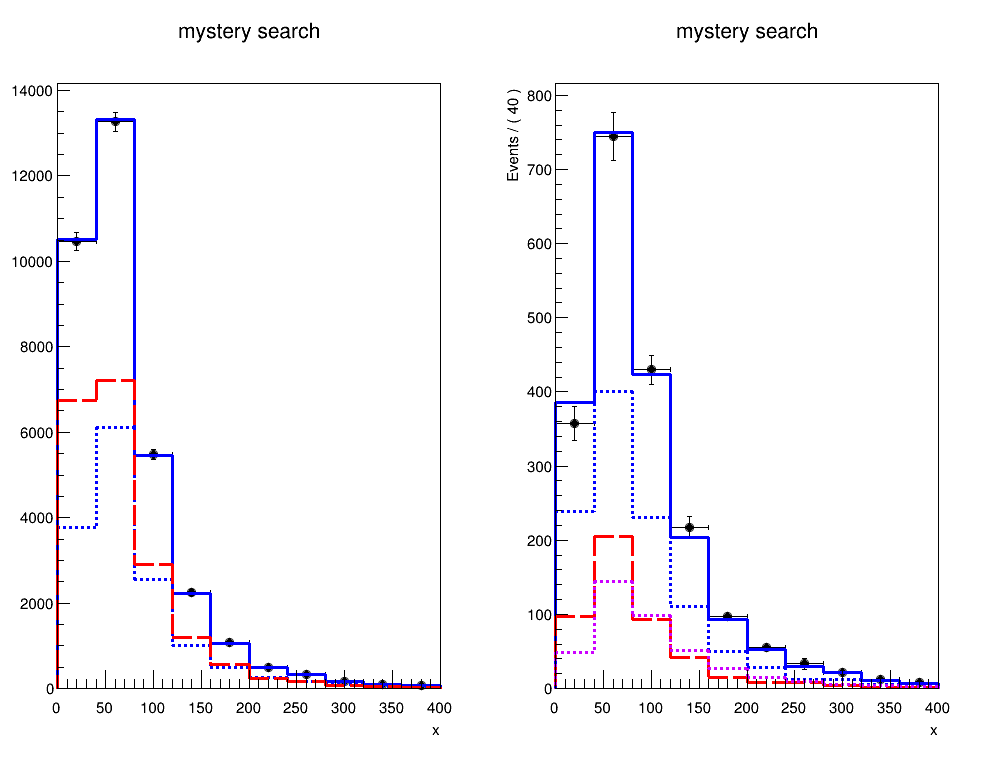

In [9]:
import ROOT 
test_file = ROOT.TFile.Open("test_fitting_hists.root")

x = ROOT.RooRealVar("x","x",0,400)

sig_hist = ROOT.RooDataHist("sig_hist","signal vs x",ROOT.RooArgList(x),test_file.Get("hsig"))
bkg1_sr_hist = ROOT.RooDataHist("bkg1_sr_hist","sr bkg1 vs x",ROOT.RooArgList(x),test_file.Get("htt"))
bkg2_sr_hist = ROOT.RooDataHist("bkg2_sr_hist","sr bkg2 vs x",ROOT.RooArgList(x),test_file.Get("hzg"))

bkg1_cr_hist = ROOT.RooDataHist("bkg1_cr_hist","cr bkg1 vs x",ROOT.RooArgList(x),test_file.Get("htt_cr"))
bkg2_cr_hist = ROOT.RooDataHist("bkg2_cr_hist","cr bkg2 vs x",ROOT.RooArgList(x),test_file.Get("zg_cr"))

data_cr_hist = ROOT.RooDataHist("data_cr_hist","cr data vs x",ROOT.RooArgList(x),test_file.Get("hdata_cr"))
data_sr_hist = ROOT.RooDataHist("data_sr_hist","sr data vs x",ROOT.RooArgList(x),test_file.Get("hdata"))

sig_pdf = ROOT.RooHistPdf("sig_pdf","signal vs x",ROOT.RooArgSet(x),sig_hist)
bkg1_sr_pdf = ROOT.RooHistPdf("bkg1_sr_pdf","sr bkg1 vs x",ROOT.RooArgSet(x),bkg1_sr_hist)
bkg2_sr_pdf = ROOT.RooHistPdf("bkg2_sr_pdf","sr bkg2 vs x",ROOT.RooArgSet(x),bkg2_sr_hist)

bkg1_cr_pdf = ROOT.RooHistPdf("bkg1_cr_pdf","cr bkg1 vs x",ROOT.RooArgSet(x),bkg1_cr_hist)
bkg2_cr_pdf = ROOT.RooHistPdf("bkg2_cr_pdf","cr bkg2 vs x",ROOT.RooArgSet(x),bkg2_cr_hist)

#data_cr_pdf = ROOT.RooHistPdf("data_cr_pdf","cr data vs x",ROOT.RooArgSet(x),data_cr_hist)
#data_sr_pdf = ROOT.RooHistPdf("data_sr_pdf","sr data vs x",ROOT.RooArgSet(x),data_sr_hist)

mu_sig = ROOT.RooRealVar("mu_sig","#signal strength",1,0.,2)
mu_bkg1 = ROOT.RooRealVar("mu_bkg1","bkg1 strength",1,0.,2)
mu_bkg2 = ROOT.RooRealVar("mu_bkg2","bkg2 strength",1,0.,2)

nsig = ROOT.RooFit.RooConst(sig_hist.sum(False))
nbkg1 = ROOT.RooFit.RooConst(bkg1_sr_hist.sum(False))
nbkg2 = ROOT.RooFit.RooConst(bkg2_sr_hist.sum(False))
nbkg1_cr = ROOT.RooFit.RooConst(bkg1_cr_hist.sum(False))
nbkg2_cr = ROOT.RooFit.RooConst(bkg2_cr_hist.sum(False))

nsig_scaled = ROOT.RooProduct("nsig_scaled", "scaled Nsig", ROOT.RooArgList(nsig, mu_sig))
nbkg1_scaled = ROOT.RooProduct("nbkg1_scaled", "scaled Nbkg1", ROOT.RooArgList(nbkg1, mu_bkg1))
nbkg2_scaled = ROOT.RooProduct("nbkg2_scaled", "scaled Nbkg2", ROOT.RooArgList(nbkg2, mu_bkg2))


nbkg1_cr_scaled = ROOT.RooProduct("nbkg1_cr_scaled", "scaled Nbkg1, CR", ROOT.RooArgList(nbkg1_cr, mu_bkg1))
nbkg2_cr_scaled = ROOT.RooProduct("nbkg2_cr_scaled", "scaled Nbkg2, CR",ROOT.RooArgList(nbkg2_cr, mu_bkg2))

model_cr = ROOT.RooAddPdf("model_cr","cr",ROOT.RooArgList(bkg1_cr_pdf,bkg2_cr_pdf),ROOT.RooArgList(nbkg1_cr_scaled,nbkg2_cr_scaled))

model = ROOT.RooAddPdf("model","sr",ROOT.RooArgList(bkg1_sr_pdf,bkg2_sr_pdf,sig_pdf),ROOT.RooArgList(nbkg1_scaled,nbkg2_scaled,nsig_scaled))

# Define category to distinguish physics and control samples events
sample = ROOT.RooCategory("sample", "sample")
sample.defineType("signal_region")
sample.defineType("control_region")

sim_model = ROOT.RooSimultaneous("sim_model","",sample) 
sim_model.addPdf(model,"signal") 
sim_model.addPdf(model_cr,"control") 

combData = ROOT.RooDataHist("combData","combined data",ROOT.RooArgList(x),ROOT.RooFit.Index(sample),
            ROOT.RooFit.Import("signal",data_sr_hist),
            ROOT.RooFit.Import("control",data_cr_hist))

result = sim_model.fitTo(combData,ROOT.RooFit.Save())

c1 = ROOT.TCanvas("c1", "c1", 1000, 800)
c1.Divide(2)
c1.cd(1)
# Construct plot frame in 'x'
xframe = x.frame(ROOT.RooFit.Title("mystery search"))  # RooPlot

# --- Plot toy data and composite PDF overlaid ---
data_cr_hist.plotOn(xframe)
model_cr.plotOn(xframe)

ras_bkg1 = ROOT.RooArgSet(bkg1_cr_pdf)
model_cr.plotOn(xframe, ROOT.RooFit.Components(ras_bkg1), ROOT.RooFit.LineStyle(ROOT.kDashed))

ras_bkg2 = ROOT.RooArgSet(bkg2_cr_pdf)
model_cr.plotOn(xframe, ROOT.RooFit.Components(ras_bkg2), ROOT.RooFit.LineStyle(9),ROOT.RooFit.LineColor(ROOT.kRed))

xframe.Draw()
c1.cd(2)
# Construct plot frame in 'x'
xframe2 = x.frame(ROOT.RooFit.Title("mystery search"))  # RooPlot

# --- Plot toy data and composite PDF overlaid ---
data_sr_hist.plotOn(xframe2)
model.plotOn(xframe2)

ras_bkg1 = ROOT.RooArgSet(bkg1_sr_pdf)
model.plotOn(xframe2, ROOT.RooFit.Components(ras_bkg1), ROOT.RooFit.LineStyle(ROOT.kDashed))

ras_bkg2 = ROOT.RooArgSet(bkg2_sr_pdf)
model.plotOn(xframe2, ROOT.RooFit.Components(ras_bkg2), ROOT.RooFit.LineStyle(9),ROOT.RooFit.LineColor(ROOT.kRed))

ras_sig = ROOT.RooArgSet(sig_pdf)
model.plotOn(xframe2, ROOT.RooFit.Components(ras_sig), ROOT.RooFit.LineStyle(2),ROOT.RooFit.LineColor(ROOT.kViolet))

xframe2.Draw()
c1.Draw()

In [28]:
print test_file.Get("zg_cr").Integral(), test_file.Get("htt_cr").Integral()
15045.7/13519.0529743

19212.6986386 13519.0529743


1.1129255894330903